In [4]:
import os
import numpy as np
import librosa
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from audiomentations import Compose, TimeStretch, PitchShift, AddGaussianNoise
from tensorflow.keras.regularizers import l2

# Define paths and parameters
DATASET_PATH = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_train/flac"
LABEL_FILE_PATH = "/data/common_source/datasets/asvpoof-2019-dataset/LA/LA/ASVspoof2019_LA_cm_protocols/ASVspoof2019.LA.cm.train.trn.txt"
NUM_CLASSES = 2  # Number of classes (bonafide and spoof)
SAMPLE_RATE = 16000  # Sample rate of your audio files
DURATION = 5  # Duration of audio clips in seconds
N_MFCC = 13  # Number of MFCC coefficients
HOP_LENGTH = 512  # Hop length for MFCC extraction
WIN_LENGTH = 1024  # Window length for MFCC extraction

labels = {}
with open(LABEL_FILE_PATH, 'r') as label_file:
    lines = label_file.readlines()

for line in lines:
    parts = line.strip().split()
    file_name = parts[1]
    label = 1 if parts[-1] == "bonafide" else 0
    labels[file_name] = label

X = []
y = []

max_time_steps = 109  # Define the maximum time steps for your model

for file_name, label in labels.items():
    file_path = os.path.join(DATASET_PATH, file_name + ".flac")

    # Load audio file using librosa
    audio, _ = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)

    # Extract MFCC features using librosa
    mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, n_fft=WIN_LENGTH)

    # Ensure all MFCC features have the same width (time steps)
    if mfcc.shape[1] < max_time_steps:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_time_steps - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_time_steps]

    X.append(mfcc)
    y.append(label)

X = np.array(X)
y = np.array(y)

2023-10-16 04:04:01.409020: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-16 04:04:01.517379: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-16 04:04:01.517397: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-16 04:04:01.540371: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-16 04:04:01.986374: W tensorflow/stream_executor/pla

In [6]:
from sklearn.model_selection import train_test_split

# Data augmentation using audiomentations
augment = Compose([
    TimeStretch(min_rate=0.8, max_rate=1.2, p=0.5),
    PitchShift(min_semitones=-2, max_semitones=2, p=0.5),
    AddGaussianNoise(min_amplitude=0.001, max_amplitude=0.015, p=0.5),
])

X_augmented = [augment(samples=x, sample_rate=SAMPLE_RATE) for x in X]

# Split the data into training (80%) and the rest (20%)
X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.2, random_state=42)

# Further split the rest into validation (50%) and test (50%)
X_val, X_test, y_val, y_test = train_test_split(X_rest, y_rest, test_size=0.5, random_state=42)

/home/sae/ENTER/envs/newconda/lib/python3.9/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=109
  warnings.warn(


In [7]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)

# Convert the class weights to a dictionary
class_weight_dict = {i: class_weights[i] for i in range(NUM_CLASSES)}

# Define and compile a CNN model with L2 regularization and other improvements
model = tf.keras.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
           kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2023-10-16 04:08:31.085225: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-16 04:08:31.085373: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-10-16 04:08:31.085464: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-10-16 04:08:31.085552: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-10-16 04:08:31.085640: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [29]:
from sklearn.utils import shuffle
# Shuffle the training data
X_train, y_train = shuffle(X_train, y_train, random_state=42)

# Shuffle the validation data (if needed)
X_validation, y_validation = shuffle(X_val, y_val, random_state=42)

# Shuffle the test data
X_test, y_test = shuffle(X_test, y_test, random_state=42)

# Train the model
num_epochs = [5, 7, 9, 10,11,13,15]
num_batch_size = 32 #number of features to train at once

#Find the best epoch
for epoch in num_epochs:

    # Define and compile a CNN model with L2 regularization and other improvements
    model = tf.keras.Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
            kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    # Train the model using class weights
    history = model.fit(np.expand_dims(X_train, -1), y_train, batch_size=num_batch_size, epochs=epoch,
                    validation_data=(np.expand_dims(X_val, -1), y_val), class_weight=class_weight_dict)
    # Evaluate the model on the test set
    test_loss, test_accuracy = model.evaluate(np.expand_dims(X_test, -1), y_test)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

# Epoch vs testing accuracy
# Epoch 5
# Test Loss: 0.5448422431945801
# Test Accuracy: 0.8664302825927734

# Epoch 7
# Test Loss: 0.19813142716884613
# Test Accuracy: 0.9669030904769897

# Epcoh 9
# Test Loss: 0.19333580136299133
# Test Accuracy: 0.9712371826171875

# Epoch 10
# Test Loss: 0.17238442599773407
# Test Accuracy: 0.9724192023277283

# Epoch 11
# Test Loss: 0.18624095618724823
# Test Accuracy: 0.9672970771789551

# Epoch 13
# Test Loss: 0.2408178448677063
# Test Accuracy: 0.9338061213493347

# Epoch 15
# Test Loss: 0.19771648943424225
# Test Accuracy: 0.9456264972686768

Epoch 1/5
635/635 [==============================] - 10s 15ms/step - loss: 2.3396 - accuracy: 0.8350 - val_loss: 1.2712 - val_accuracy: 0.8924
Epoch 2/5
635/635 [==============================] - 9s 15ms/step - loss: 1.0501 - accuracy: 0.8788 - val_loss: 0.8246 - val_accuracy: 0.8920
Epoch 3/5
635/635 [==============================] - 10s 15ms/step - loss: 0.6944 - accuracy: 0.9064 - val_loss: 0.5629 - val_accuracy: 0.9370
Epoch 4/5
635/635 [==============================] - 10s 15ms/step - loss: 0.4819 - accuracy: 0.9306 - val_loss: 0.3914 - val_accuracy: 0.9444
Epoch 5/5
80/80 [==============================] - 0s 5ms/step - loss: 0.5448 - accuracy: 0.8664
Test Loss: 0.5448422431945801
Test Accuracy: 0.8664302825927734
Epoch 1/7
635/635 [==============================] - 10s 15ms/step - loss: 1.9835 - accuracy: 0.8247 - val_loss: 1.0394 - val_accuracy: 0.9043
Epoch 2/7
635/635 [==============================] - 10s 15ms/step - loss: 0.8825 - accuracy: 0.8755 - val_loss: 0.6136 - val

In [9]:
# Final pick of epoch num and threshold
model = tf.keras.Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(N_MFCC, max_time_steps, 1),
        kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Train the model using class weights
history = model.fit(np.expand_dims(X_train, -1), y_train, batch_size=32, epochs=10,
                validation_data=(np.expand_dims(X_val, -1), y_val), class_weight=class_weight_dict)
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(np.expand_dims(X_test, -1), y_test)


# Make predictions on the testing set
y_test_pred = model.predict(X_test)

Epoch 1/10
635/635 [==============================] - 10s 15ms/step - loss: 2.3614 - accuracy: 0.8168 - val_loss: 1.1310 - val_accuracy: 0.8775
Epoch 2/10
635/635 [==============================] - 10s 15ms/step - loss: 0.8967 - accuracy: 0.8885 - val_loss: 0.6743 - val_accuracy: 0.9066
Epoch 3/10
635/635 [==============================] - 10s 15ms/step - loss: 0.5972 - accuracy: 0.9045 - val_loss: 0.5561 - val_accuracy: 0.8846
Epoch 4/10
635/635 [==============================] - 10s 15ms/step - loss: 0.4312 - accuracy: 0.9175 - val_loss: 0.3309 - val_accuracy: 0.9385
Epoch 5/10
635/635 [==============================] - 10s 15ms/step - loss: 0.3496 - accuracy: 0.9235 - val_loss: 0.2860 - val_accuracy: 0.9381
Epoch 6/10
635/635 [==============================] - 9s 15ms/step - loss: 0.2951 - accuracy: 0.9255 - val_loss: 0.3871 - val_accuracy: 0.8708
Epoch 7/10
635/635 [==============================] - 10s 15ms/step - loss: 0.2722 - accuracy: 0.9274 - val_loss: 0.3188 - val_accuracy: 

IndexError: index 1 is out of bounds for axis 1 with size 1

In [10]:
y_test_pred_thresholded = (y_test_pred > 0.9).astype(int)

In [11]:
#recision/recall calculation - use 0.7 threshold for now, do not run this code unless we want to test out recall/precision
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score

#Store accuracy and precision/recall
fold_precisions = []
fold_recalls = []

#F1 scores
fold_f1_scores = []
fold_half_scores = []
fold_double_scores = []

import numpy as np
# Initialize an array of threshold values (e.g., from 0.1 to 0.9)
thresholds = np.arange(0.1, 1.0, 0.1)

#save confusion matrix
fold_cm = []

# le = LabelEncoder()
# num_epochs = 3
# num_batch_size = 32

# Train the model

# le = LabelEncoder()
# y_train_encoded = to_categorical(le.fit_transform(y_train))
# y_validation_encoded = to_categorical(le.transform(y_validation))
# y_test_encoded = to_categorical(le.transform(y_test))


for threshold in thresholds:
    y_test_pred_thresholded = (y_test_pred > threshold).astype(int)  # Adjust the column index if needed
    cm = confusion_matrix(y_test, y_test_pred_thresholded)

    # Calculate TP, FP, FN for the current threshold
    precision = precision_score(y_test, y_test_pred_thresholded)
    recall = recall_score(y_test, y_test_pred_thresholded) 

    # Calculate F1 score using precision and recall
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    fhalf = (1 + 0.5**2) * (precision * recall) / (0.5**2 * precision + recall) if (precision + recall) > 0 else 0
    fdouble = (1 + 2**2) * (precision * recall) / (2**2 * precision + recall) if (precision + recall) > 0 else 0
    
    fold_precisions.append(precision)
    fold_recalls.append(recall)
    fold_cm.append(cm)
    fold_f1_scores.append(f1)
    fold_half_scores.append(fhalf)
    fold_double_scores.append(fdouble)

Fold 0.1   Precision:  0.35766423357664234   Recall:  0.9959349593495935
F1 Score:  0.5263157894736842 F-0.5 Score:  0.4102478231748158 F-2 Score:  [0.7339724385859796, 0.7765754296626353, 0.8078457446808511, 0.831615120274914, 0.8362738179251941, 0.8545454545454547, 0.8614232209737828, 0.8372093023255816, 0.8164915117219079]

Fold 0.2   Precision:  0.41567291311754684   Recall:  0.991869918699187
F1 Score:  0.5858343337334934 F-0.5 Score:  0.4703161141094834 F-2 Score:  [0.7339724385859796, 0.7765754296626353, 0.8078457446808511, 0.831615120274914, 0.8362738179251941, 0.8545454545454547, 0.8614232209737828, 0.8372093023255816, 0.8164915117219079]

Fold 0.30000000000000004   Precision:  0.4673076923076923   Recall:  0.9878048780487805
F1 Score:  0.6344647519582245 F-0.5 Score:  0.5223559759243337 F-2 Score:  [0.7339724385859796, 0.7765754296626353, 0.8078457446808511, 0.831615120274914, 0.8362738179251941, 0.8545454545454547, 0.8614232209737828, 0.8372093023255816, 0.8164915117219079]


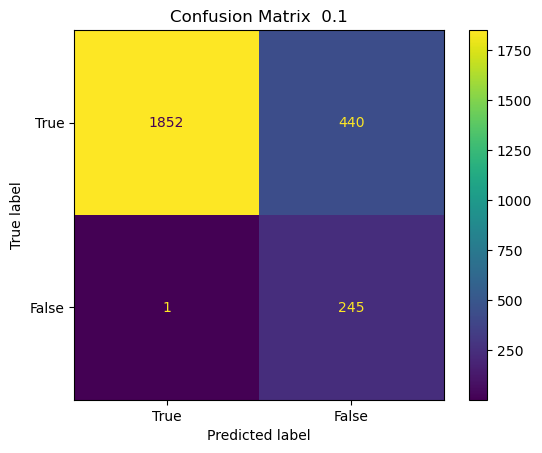

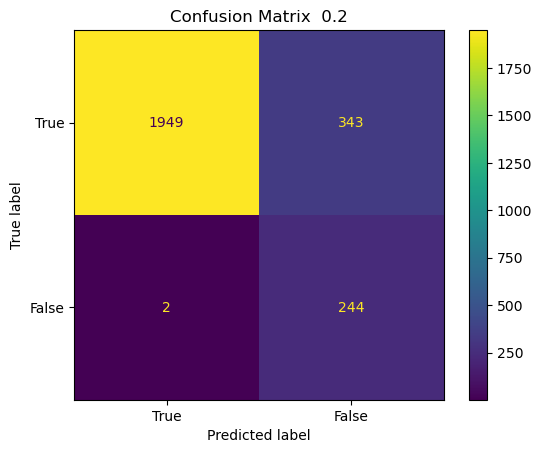

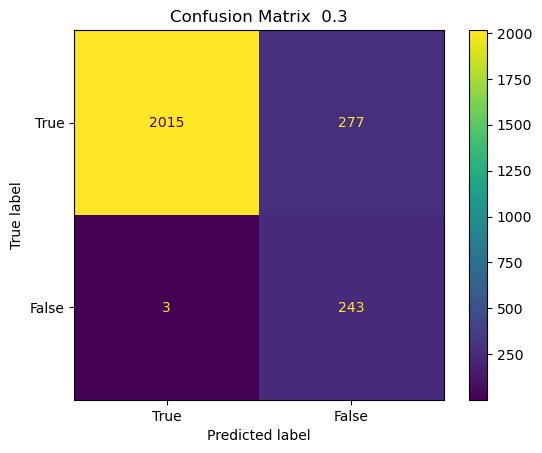

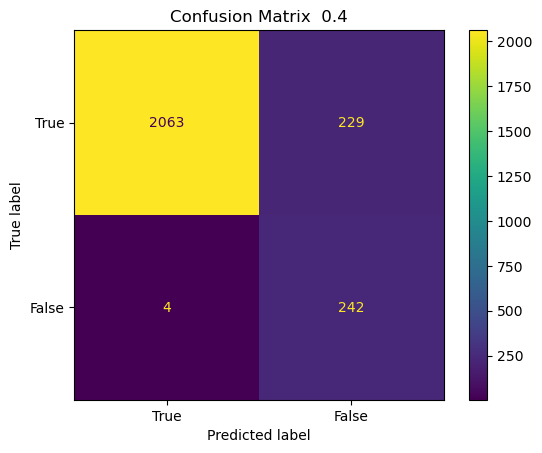

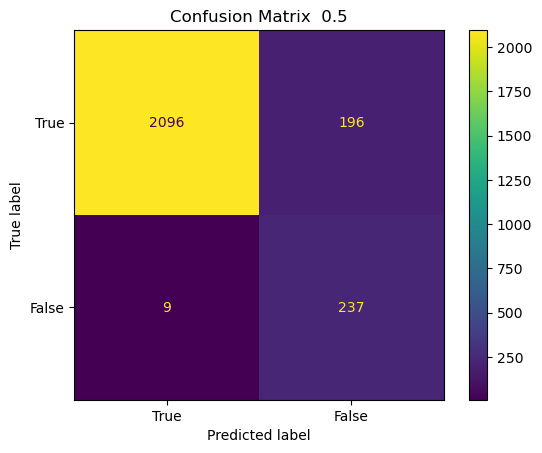

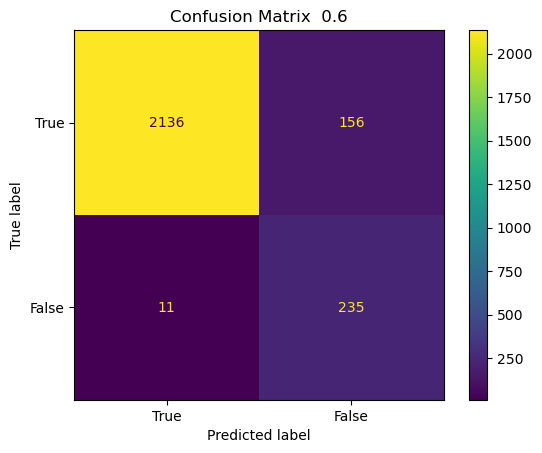

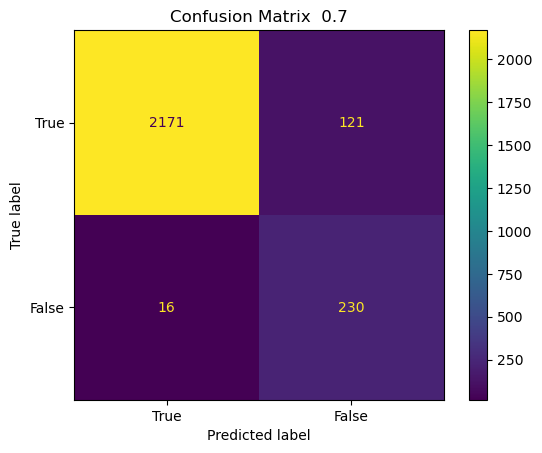

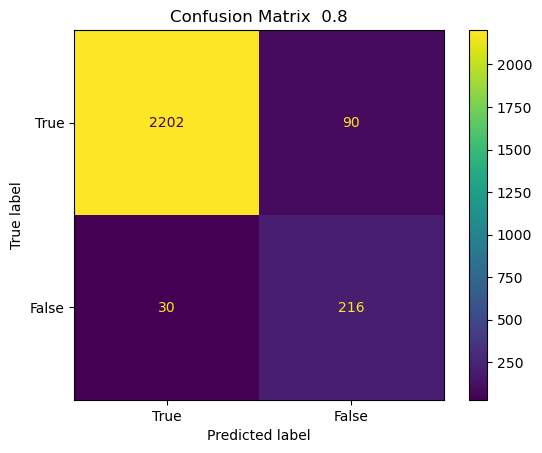

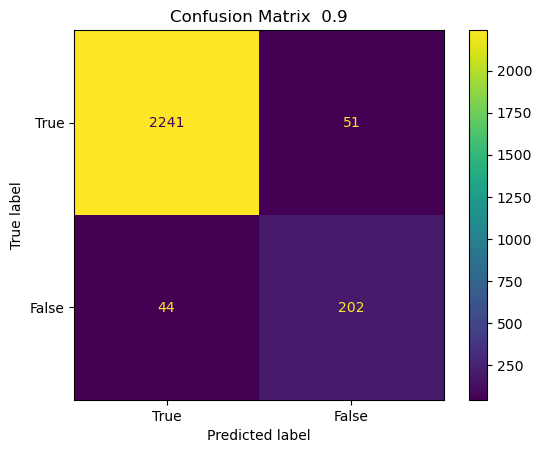

In [13]:
import matplotlib.pyplot as plt
# Calculate mean F1 scores over all folds
mean_f1_scores = np.mean(fold_f1_scores, axis=0)
mean_fhalf_scores = np.mean(fold_half_scores, axis=0)
mean_fdouble_scores = np.mean(fold_double_scores, axis=0)
mean_recall = np.mean(fold_recalls, axis=0)
mean_precision = np.mean(fold_precisions, axis=0)

for i in range(len(thresholds)):
     print("Fold", i*0.1+0.1, "  Precision: ", fold_precisions[i], "  Recall: ", fold_recalls[i])
     print("F1 Score: ", fold_f1_scores[i], "F-0.5 Score: ", fold_half_scores[i], "F-2 Score: ", fold_double_scores)
     print()

print("  Mean precision: ", mean_precision, "  Mean recall: ", mean_recall)
print(" Mean F1 Score: ", mean_f1_scores)
print(" Mean F-0.5 Score: ", mean_fhalf_scores)
print(" Mean F-0.5 Score: ", mean_fdouble_scores)


#Print confusion matrix
import matplotlib.pyplot as metrics
from sklearn.metrics import ConfusionMatrixDisplay

for i in range(len(fold_cm)):
    cm_display = ConfusionMatrixDisplay(confusion_matrix = fold_cm[i], display_labels = [True, False])
    cm_display.plot()
    title = i * 0.1+0.1
     
    plt.title(f'Confusion Matrix {title: .1f}')
    plt.show()
    
    
#pick 0.9 as threshold for now, but we might have to priotize recalls moving on

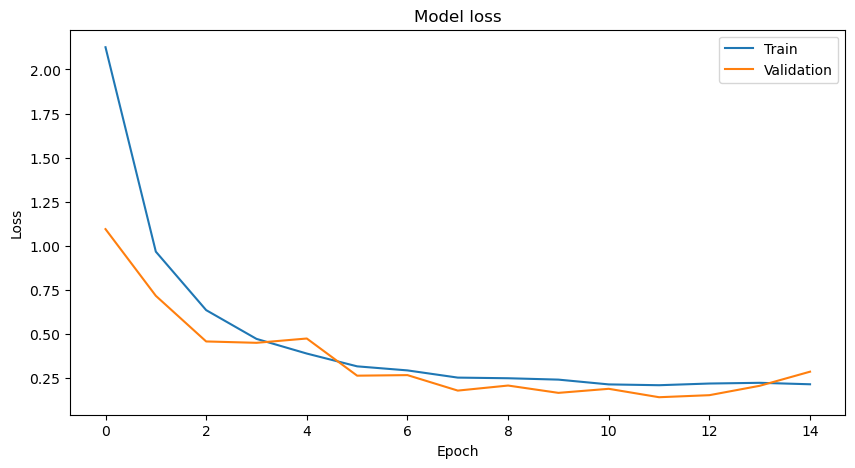

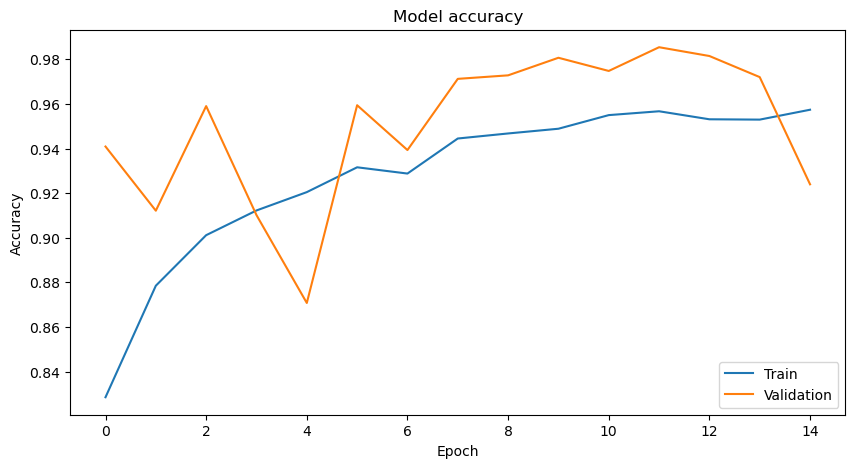

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [8]:
# Evaluate the model on the pseudo-test set
pseudo_test_loss, pseudo_test_accuracy = model.evaluate(np.expand_dims(X_val, -1), y_val)
print(f"Pseudo Test Loss: {pseudo_test_loss}")
print(f"Pseudo Test Accuracy: {pseudo_test_accuracy}")

159/159 [==============================] - 1s 4ms/step - loss: 0.1273 - accuracy: 0.9803
Pseudo Test Loss: 0.12726743519306183
Pseudo Test Accuracy: 0.9802994728088379
